<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/hands-on-generative-ai-with-transformers-and-diffusion-models/04_diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
%%capture

!pip install genaibook
!pip install datasets

In [20]:
import datasets
import diffusers
import huggingface_hub

import torch
from torch.nn import functional as F
from torchvision import transforms

from diffusers import DDPMPipeline
from diffusers import DDPMScheduler
from diffusers import UNet2DModel

from datasets import load_dataset

from genaibook.core import get_device
from genaibook.core import plot_noise_and_denoise
from genaibook.core import show_images

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
datasets.logging.set_verbosity_error()
diffusers.logging.set_verbosity_error()
huggingface_hub.logging.set_verbosity_error()

In [4]:
device = get_device()

## Iterative Refinement

In [ ]:
# Load the pipeline
image_pipeline = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256").to(device)

  0%|          | 0/1000 [00:00<?, ?it/s]

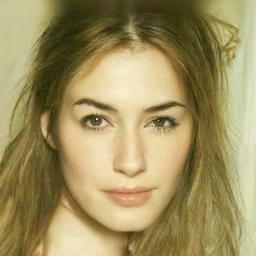

In [ ]:
# Sample an image
image = image_pipeline().images[0]
image

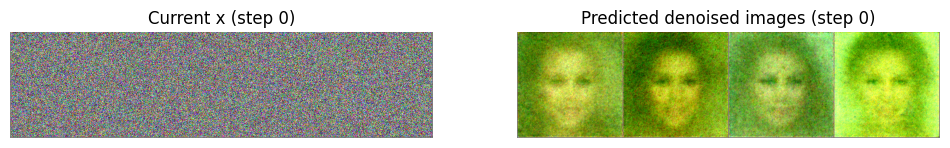

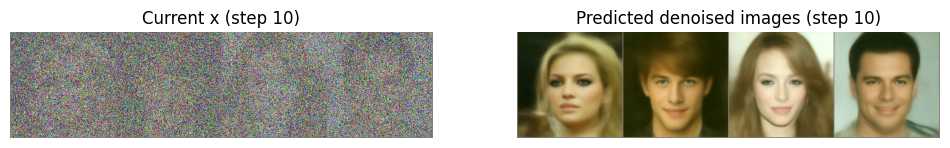

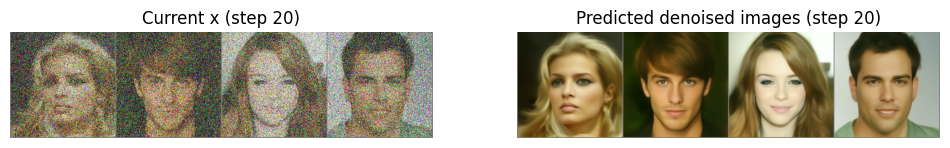

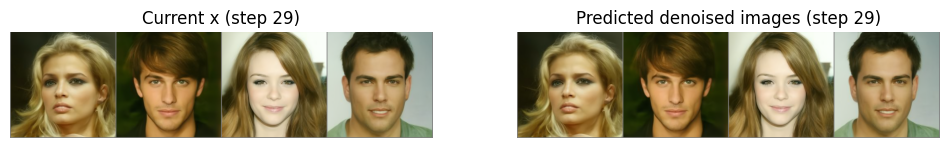

In [ ]:
# The random starting point is a batch of 4 images
# Each image is 3-channel (RGB) 256x256 pixel image
image = torch.randn(4, 3, 256, 256).to(device)

# Set the specific number of diffusion steps
image_pipeline.scheduler.set_timesteps(num_inference_steps=30)

# Loop through the sampling timesteps
for i, t in enumerate(image_pipeline.scheduler.timesteps):
  # # Get the prediction given the current sample x and the timestep t
  with torch.inference_mode():
    # We need to pass in the timestep t so that the model knows what timestep it's currently at.
    noise_pred = image_pipeline.unet(image, t)["sample"]
  # Calculate what the updated x should look like with the scheduler
  scheduler_output = image_pipeline.scheduler.step(noise_pred, t, image)

  # Update x
  image = scheduler_output.prev_sample

  # Occasionally display both x and the predicted denoised images
  if i % 10 == 0 or i == len(image_pipeline.scheduler.timesteps) - 1:
    plot_noise_and_denoise(scheduler_output, i)

## Training Diffusion Model

###Dataset

In [ ]:
# let's load dataset
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

In [6]:
image_size = 64

# Define transformations
preprocess = transforms.Compose(
   [
       transforms.Resize((image_size, image_size)), # Resize
      transforms.RandomHorizontalFlip(),            # Randomly flip (data augmentation)
      transforms.ToTensor(),                        # Convert to tensor (0, 1)
      transforms.Normalize([0.5], [0.5]),           # Map to (-1, 1)
   ]
)

In [7]:
def transform(examples):
  images = [preprocess(image) for image in examples["image"]]
  return {"images": images}

dataset.set_transform(transform)

In [8]:
batch_size = 16

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

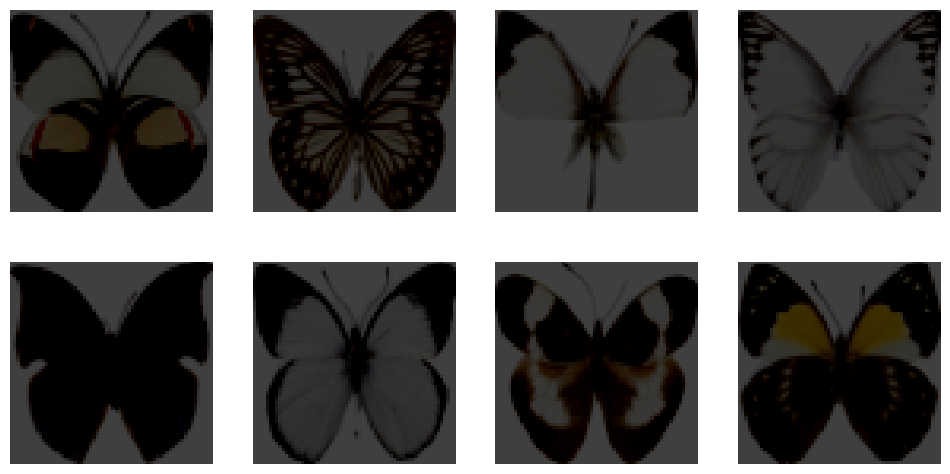

In [9]:
# let's load a batch and inspecting the images
batch = next(iter(train_dataloader))

# When we normalized, we mapped (0, 1) to (-1, 1)
# Now we map back to (0, 1) for display
show_images((batch["images"][:8] * 0.5 * 0.5).clip(0, 1))

### Add Noise

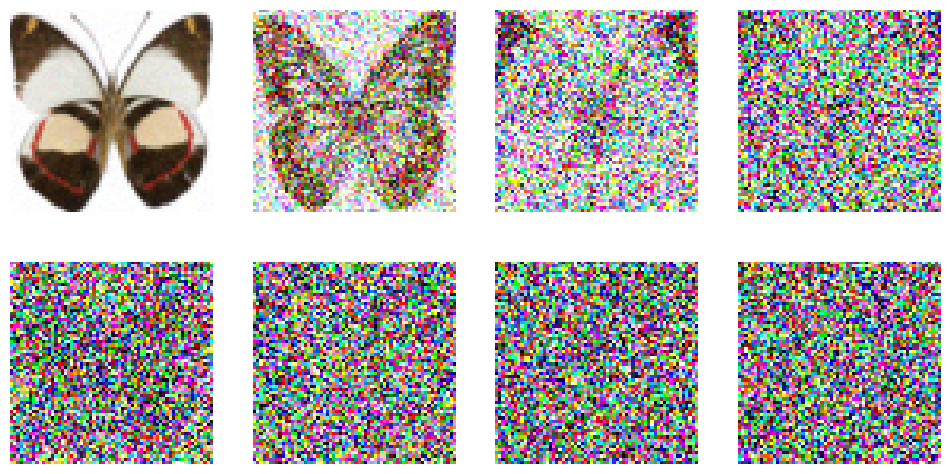

In [10]:
# adding noise is handled by a class called a Scheduler
scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.001,
    beta_end=0.02,
)

# Create a tensor with 8 evenly spaced values from 0 to 999
timesteps = torch.linspace(0, 999, 8).long()

# We load 8 images from the dataset and add increasing amounts of noise to them
x = batch["images"][:8]
noise = torch.randn_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)

show_images((noised_x * 0.5 + 0.5).clip(0, 1))

###The UNet

In [13]:
# let's create a UNet and feed our batch of noisy images through it
model = UNet2DModel(
    sample_size=64, # Specify our input size
    in_channels=3,  # 3 channels for RGB images
    block_out_channels=(64, 128, 256, 512), # How many channels each block will have
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    )
).to(device)

In [15]:
# Pass a batch of data through to make sure it works
with torch.inference_mode():
  output = model(noised_x.to(device), timestep=timesteps.to(device)).sample
print(noised_x.shape)
print(output.shape)

torch.Size([8, 3, 64, 64])
torch.Size([8, 3, 64, 64])


###Training

In [17]:
batch_size = 32

def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}

# We reset to the initial size (64)
dataset.set_transform(transform)
image_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

In [19]:
num_epochs = 50 # How many runs through the data should we do?
lr = 1e-4       # What learning rate should we use
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
losses = []     # Somewhere to store the loss values for later plotting

# Train the model (this takes a while)
for epoch in range(num_epochs):
  for batch in train_dataloader:
    # Load the input images
    clean_images = batch["images"].to(device)

    # Sample noise to add to the images
    noise = torch.randn(clean_images.shape).to(device)

    # Sample a random timestep for each image
    timesteps = torch.randint(
        0,
        scheduler.config.num_train_timesteps,
        (clean_images.shape[0],),
        device=device,
    ).long()

    # Add noise to the clean images according to the noise magnitude at each timestep
    noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

    # Get the model prediction for the noise
    # The model also uses the timestep as an input
    # for additional conditioning
    noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

    # Compare the prediction with the actual noise
    loss = F.mse_loss(noise_pred, noise)

    # Store the loss for later plotting
    losses.append(loss.item())

    # Backpropagate the loss and update the model
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  # Print out the average of the loss values for this epoch:
  avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
  print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

Finished epoch 0. Average loss for this epoch: 0.124732
Finished epoch 1. Average loss for this epoch: 0.070746
Finished epoch 2. Average loss for this epoch: 0.055722
Finished epoch 3. Average loss for this epoch: 0.047358
Finished epoch 4. Average loss for this epoch: 0.039898
Finished epoch 5. Average loss for this epoch: 0.034553
Finished epoch 6. Average loss for this epoch: 0.034568
Finished epoch 7. Average loss for this epoch: 0.028391
Finished epoch 8. Average loss for this epoch: 0.027184
Finished epoch 9. Average loss for this epoch: 0.030536
Finished epoch 10. Average loss for this epoch: 0.028312
Finished epoch 11. Average loss for this epoch: 0.025880
Finished epoch 12. Average loss for this epoch: 0.026337
Finished epoch 13. Average loss for this epoch: 0.027655
Finished epoch 14. Average loss for this epoch: 0.026530
Finished epoch 15. Average loss for this epoch: 0.022955
Finished epoch 16. Average loss for this epoch: 0.023430
Finished epoch 17. Average loss for this 

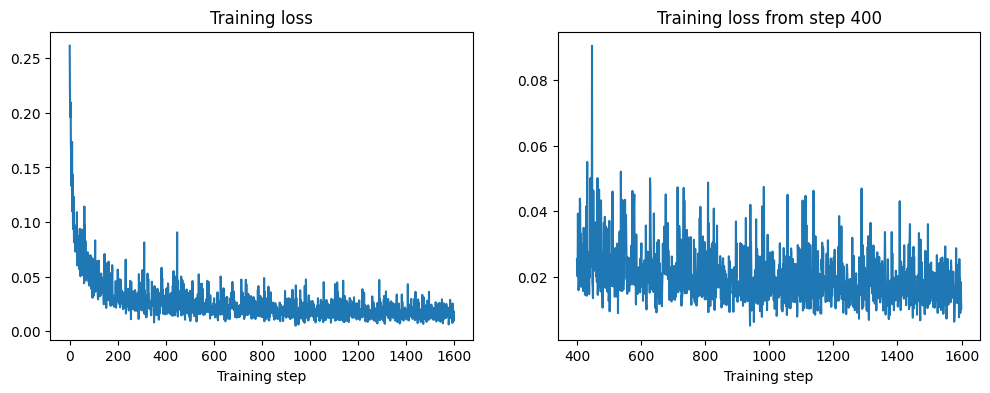

In [21]:
plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Training step")

plt.subplot(1, 2, 2)
plt.plot(range(400, len(losses)), losses[400:])
plt.title("Training loss from step 400")
plt.xlabel("Training step");

###Sampling